tgb - 1/22/2020 - The goal of this notebook is to reproduce the multiple panels of notebook 017 in a single figure, from reduced data.

# Initialization

In [1]:
!rm util # Run if util folder already exists, will produce an error otherwise

rm: cannot remove ‘util’: No such file or directory


In [2]:
!ln -s ../../util util # Symlink to utilities folder

## Imports

In [3]:
# Initial imports
import util.Landau_Potential_Diffusion as Landau
import util.curvature as curve
import util.pdf as PDF

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.transforms as mtransforms
import datetime
from skimage import measure
from scipy import ndimage, stats
import scipy.integrate as sin
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter1d
import random
import pandas as pd

import pickle

/home/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/core/merge.py:18: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:1829: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  'DataArray', pd.Series, pd.DataFrame, pd.Panel]:


In [4]:
# Figure characteristics common to all Figures
fz = 15
lw = 3
siz = 10

plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
mpl.rcParams['lines.markersize'] = siz
plt.close('all')

# Physical constants
stday = 24*3600

## Utilities

In [5]:
class Bunch(object):
  
    def __init__(self, adict):
        self.__dict__.update(adict)

In [6]:
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

In [7]:
def get_all_values(dic_values):
    values = []
    for i_k, key in enumerate(dic_values.keys()):
        values.extend(dic_values[key])
    return values

In [8]:
def find_index(time_A, time_cond):
    ind = np.where(time_A == time_cond)[0][0]
    return ind

In [9]:
def bin_mid_to_edge(binm):
    bine = 0.5*(binm[:-1]+binm[1:]) # bin_edges[1:-1]
    return np.concatenate(([bine[0]-(bine[2]-bine[1])],bine,[bine[-1]+(bine[2]-bine[1])]))

# Load reduced data

In [10]:
pathPKL = '../../dev/tbeucler/PKL_DATA/'
hf = open(pathPKL+'2020_01_20_MSE_a.pkl','rb')
S = pickle.load(hf)
A = Bunch(S)
hf.close()

In [11]:
hf = open(pathPKL+'2020_01_20_MSE_b.pkl','rb')
S = pickle.load(hf)
B = Bunch(S)
hf.close()

In [12]:
hf = open(pathPKL+'2020_01_20_MSE_c.pkl','rb')
S = pickle.load(hf)
C0 = Bunch(S)
hf.close()

In [13]:
hf = open(pathPKL+'2020_01_20_MSE_c2.pkl','rb')
S = pickle.load(hf)
C = Bunch(S)
hf.close()

In [14]:
hf = open(pathPKL+'2020_01_20_MSE_d.pkl','rb')
S = pickle.load(hf)
D = Bunch(S)
hf.close()

In [17]:
hf = open(pathPKL+'10_15_VCOSMO.pkl','rb')
S = pickle.load(hf)
E = Bunch(S)
hf.close()

In [18]:
hf = open(pathPKL+'2020_02_05_MSE_total.pkl','rb')
S = pickle.load(hf)
F = Bunch(S)
hf.close()

In [20]:
hf = open(pathPKL+'2020_05_02_VCOSMO.pkl','rb')
S = pickle.load(hf)
G = Bunch(S)
hf.close()

In [21]:
hf = open(pathPKL+'2020_02_05_MSE_anomaly.pkl','rb')
S = pickle.load(hf)
H = Bunch(S)
hf.close()

# Make six-panel Figure

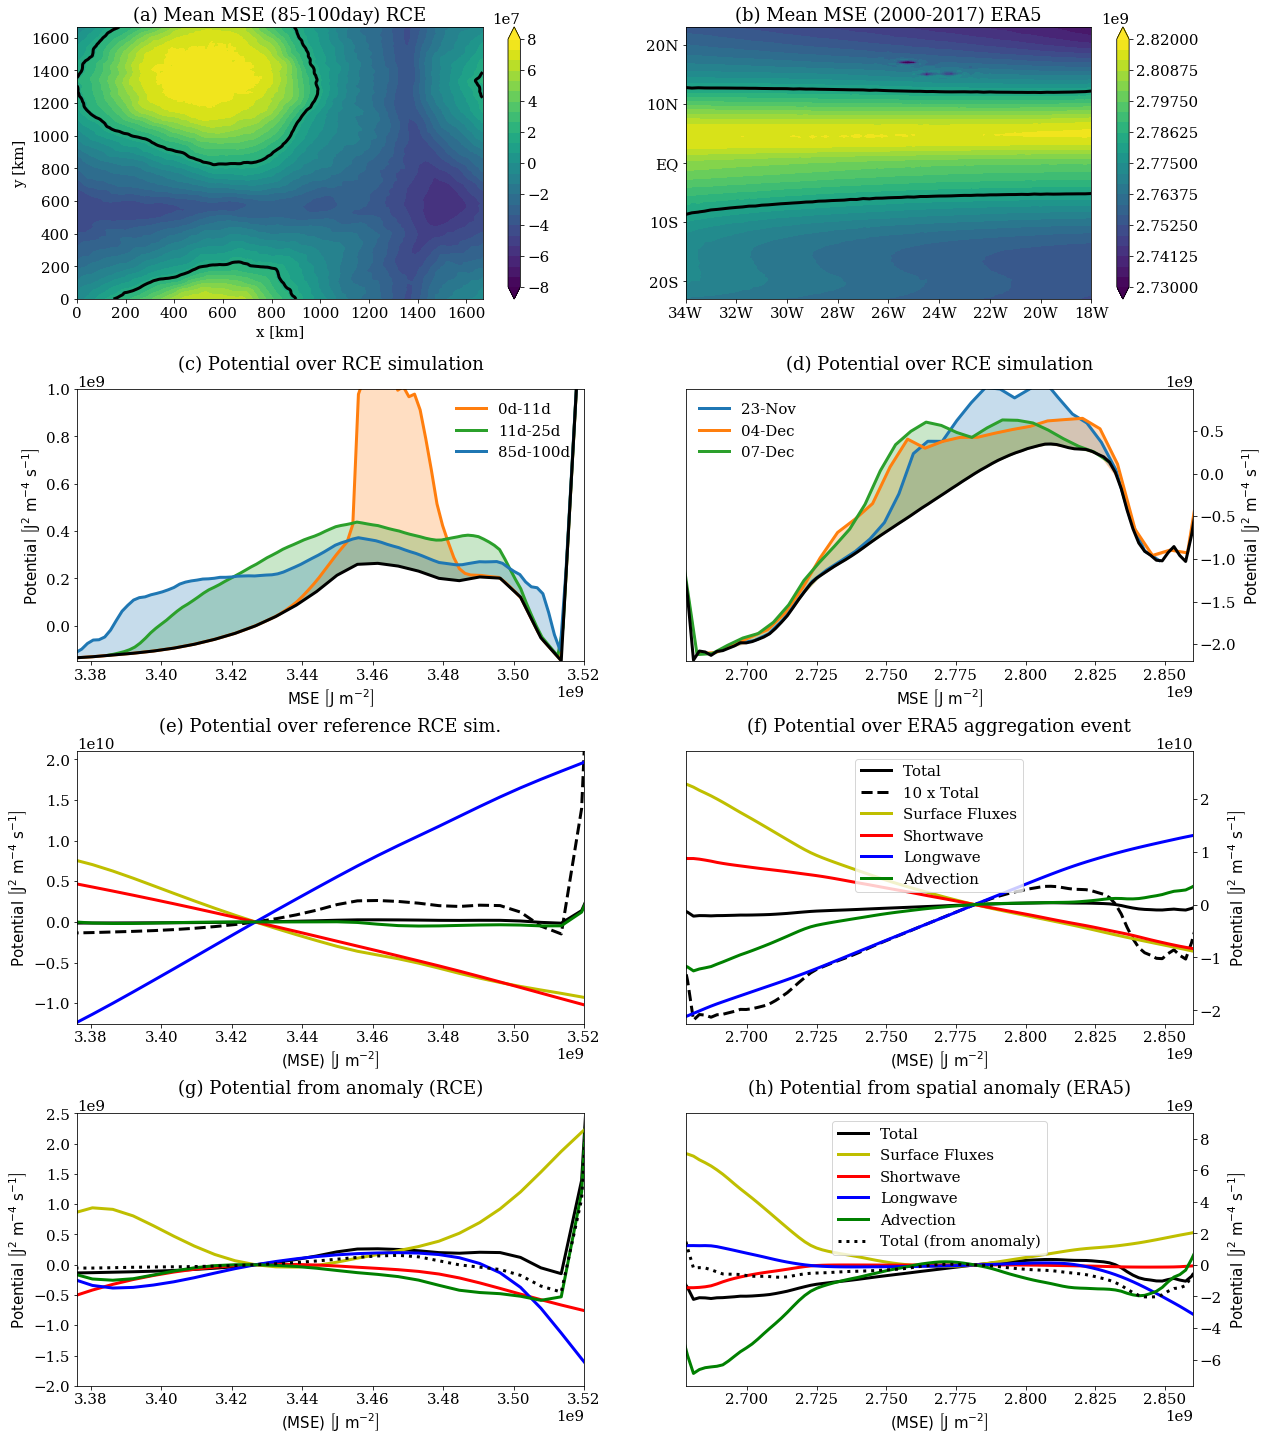

In [22]:
fig,axes = plt.subplots(4,2,figsize=(20,25))
plt.subplots_adjust(hspace=0.33)
# Panel a
ax = axes[0][0]
ax.contour(A.x,A.y, A.toplot,[A.COAR_p88[0]],colors='k')
cont_levels = np.linspace(-8e7,8e7,25)
im = ax.contourf(A.x, A.y, A.toplot-A.toplot.mean(), cont_levels,
                 vmin = -8e7, vmax = 8e7, extend='both')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('(a) Mean MSE (85-100day) RCE')
cbar = fig.colorbar(im,ax=ax)
# Panel c
ax = axes[1][0]
ax.set_xlim((3.376e9,3.52e9))
ax.set_ylim((-1.5e8,1e9))
ax.set_xlabel(r'$\mathrm{MSE}\ \left[\mathrm{J\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{Potential\ \left[J^{2}\ m^{-4}\ s^{-1}\right]}$')
scale_factor = 2e16
ax.fill_between((edgTObin(C.SPINedges)),C.VSPIN,C.VSPIN+C0.MSE_PDF_SPIN*scale_factor,color=C.SPINrgb, alpha = 0.25)
ax.fill_between((edgTObin(C.COALedges)),C.VCOAL,C.VCOAL+C0.MSE_PDF_COAL*scale_factor,color=C.COALrgb, alpha = 0.25)
ax.fill_between((edgTObin(C.COARedges)),C.VCOAR,C.VCOAR+C0.MSE_PDF_COAR*scale_factor,color=C.COARrgb, alpha = 0.25)
ax.plot((edgTObin(C.SPINedges)),C.VSPIN+C0.MSE_PDF_SPIN*scale_factor,color=C.SPINrgb,label='0d-11d')
ax.plot((edgTObin(C.COALedges)),C.VCOAL+C0.MSE_PDF_COAL*scale_factor,color=C.COALrgb,label='11d-25d')
ax.plot((edgTObin(C.COARedges)),C.VCOAR+C0.MSE_PDF_COAR*scale_factor,color=C.COARrgb,label='85d-100d')
ax.legend(frameon=False,loc='upper right')
ax.plot(C.binm,C.Vtot,color='k')
ax.set_title('(c) Potential over RCE simulation',pad=20)
# Panel e
ax = axes[2][0]
X_pot = E.binm
ax.plot(X_pot,E.Vtot,color='k',label='Total')
ax.plot(X_pot,10*E.Vtot,color='k',label='10 x Total',linestyle='--')
ax.plot(X_pot,E.Vsef,color='y',label='Surface Fluxes')
ax.plot(X_pot,E.Vsw,color='r',label='Shortwave')
ax.plot(X_pot,E.Vlw,color='b',label='Longwave')
ax.plot(X_pot,E.Vadv,color='g',label='Advection')
ax.set_xlim((3.376e9,3.52e9))
ax.set_ylim((-1.25e10,2.1e10))
ax.set_title('(e) Potential over reference RCE sim.',pad=20)
ax.set_xlabel(r'$\left(\mathrm{MSE}\right)\ \left[\mathrm{J\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{Potential\ \left[J^{2}\ m^{-4}\ s^{-1}\right]}$')
#ax.legend()
# Panel g
ax = axes[3][0]
X_pot = G.binm
ax.plot(X_pot,E.Vtot,color='k',label='Total')
ax.plot(X_pot,G.Vsef,color='y',label='Surface Fluxes')
ax.plot(X_pot,G.Vsw,color='r',label='Shortwave')
ax.plot(X_pot,G.Vlw,color='b',label='Longwave')
ax.plot(X_pot,G.Vadv,color='g',label='Advection')
ax.plot(X_pot,G.Vtot,color='k',label='Total (from anomaly)',linestyle=':')
ax.set_xlim((3.376e9,3.52e9))
ax.set_ylim((-2e9,2.5e9))
ax.set_title('(g) Potential from anomaly (RCE)',pad=20)
ax.set_xlabel(r'$\left(\mathrm{MSE}\right)\ \left[\mathrm{J\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{Potential\ \left[J^{2}\ m^{-4}\ s^{-1}\right]}$')
#ax.legend()
# Panel b
ax = axes[0][1]
ax.contour(B.lonAtl, B.latAtl, B.toplot, [B.p67_MSE], colors=['k'])#, vmin = 2.7e9, vmax=2.85e9)
VMIN = 2.73e9
VMAX = 2.82e9
cont_levels = np.linspace(VMIN,VMAX,25)
im = ax.contourf(B.lonAtl, B.latAtl, B.toplot, cont_levels, vmin = VMIN, vmax = VMAX, extend='both')
locs = ax.get_xticks()
labels = list(np.arange(len(locs)))
for i_l, loc in enumerate(locs):
    labels[i_l] = '%iW'%int(360-loc)
ax.set_xticklabels(labels) 
locs = ax.get_yticks()
labels = list(np.arange(len(locs)))
for i_l, loc in enumerate(locs):
    if loc >0:
        labels[i_l] = '%iN'%int(loc)
    elif loc == 0:
        labels[i_l] = 'EQ'
    else:
        labels[i_l] = '%iS'%int(loc*-1)
ax.set_yticklabels(labels)
ax.set_title('(b) Mean MSE (2000-2017) ERA5')
cbar = fig.colorbar(im,ax=ax)
# Panel d
scale_factor = 5e16
ax = axes[1][1]
ax.set_ylim((-2.2e9,0.99e9))
ax.set_xlim((2.678e9,2.86e9))
ax.set_xlabel(r'$\mathrm{MSE}\ \left[\mathrm{J\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{Potential\ \left[J^{2}\ m^{-4}\ s^{-1}\right]}$')
for i in range(3):
    ax.fill_between((edgTObin(D.edgesmse[i])),np.interp(x=edgTObin(D.edgesmse[i]),xp=D.binm,fp=D.V),
                    np.interp(x=edgTObin(D.edgesmse[i]),xp=D.binm,fp=D.V)+D.pdfmse[i]*scale_factor,
                    color=D.col_A[i], alpha = 0.25)
for i in range(3):
    ax.plot((edgTObin(D.edgesmse[i])),
            np.interp(x=edgTObin(D.edgesmse[i]),xp=D.binm,fp=D.V)+D.pdfmse[i]*scale_factor,
            color=D.col_A[i],label=D.times_labels[i])
ax.legend(frameon=False,loc='upper left')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.plot(D.binm,D.V,color='k')
ax.set_title('(d) Potential over RCE simulation',pad=20)
# Panel f
ax = axes[2][1]
X_pot = F.binm
ax.plot(X_pot,F.Vtot,color='k',label='Total')
ax.plot(X_pot,10*F.Vtot,color='k',label='10 x Total',linestyle='--')
ax.plot(X_pot,F.Vsef,color='y',label='Surface Fluxes')
ax.plot(X_pot,F.Vsw,color='r',label='Shortwave')
ax.plot(X_pot,F.Vlw,color='b',label='Longwave')
ax.plot(X_pot,F.Vadv,color='g',label='Advection')
ax.set_title('(f) Potential over ERA5 aggregation event',pad=20)
ax.set_xlabel(r'$\left(\mathrm{MSE}\right)\ \left[\mathrm{J\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{Potential\ \left[J^{2}\ m^{-4}\ s^{-1}\right]}$')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xlim((2.678e9,2.86e9))
ax.set_ylim((-2.25e10,2.9e10))
ax.legend()
# Panel h
ax = axes[3][1]
X_pot = H.binm
ax.plot(X_pot,F.Vtot,color='k',label='Total')
ax.plot(X_pot,H.Vsef,color='y',label='Surface Fluxes')
ax.plot(X_pot,H.Vsw,color='r',label='Shortwave')
ax.plot(X_pot,H.Vlw,color='b',label='Longwave')
ax.plot(X_pot,H.Vadv,color='g',label='Advection')
ax.plot(X_pot,H.Vtot,color='k',label='Total (from anomaly)',linestyle=':')
ax.set_title('(h) Potential from spatial anomaly (ERA5)',pad=20)
ax.set_xlabel(r'$\left(\mathrm{MSE}\right)\ \left[\mathrm{J\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{Potential\ \left[J^{2}\ m^{-4}\ s^{-1}\right]}$')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xlim((2.678e9,2.86e9))
#ax.set_ylim((-5.8e10,2.9e10))
ax.legend()
# Save figure
path_home = '/users/tbeucler/'
plt.draw()
plt.savefig('Fig_B1.pdf',format='pdf')